In [4]:
!pip install gdown

In [ ]:
!pip install tensorflow==2.9.0

In [5]:
!gdown --id 1NWEJE9d0fbwe_eKBIE788w9RgUTmYgeo

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1NWEJE9d0fbwe_eKBIE788w9RgUTmYgeo
From (redirected): https://drive.google.com/uc?id=1NWEJE9d0fbwe_eKBIE788w9RgUTmYgeo&confirm=t&uuid=549c228c-3760-461e-833f-7cb78936d123
To: /kaggle/working/dataset.zip
100%|█████████████████████████████████████████| 395M/395M [00:01<00:00, 201MB/s]


In [6]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
import math
# Extract ZIP file
zip_file_path = 'dataset.zip'
extract_dir = 'kaggle/working/datasett'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Verify extraction
print(f"Contents of '{extract_dir}': {os.listdir(extract_dir)}")

# Define paths
images_dir = extract_dir  # The directory where images are extracted
train_dir = os.path.join('data', 'train')
val_dir = os.path.join('data', 'validation')

# Create train and validation directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Create a function to split images into train and validation sets
def split_dataset(images_dir, train_dir, val_dir, val_split=0.2):
    classes = os.listdir(images_dir)
    print(f"Found classes: {classes}")
    
    for cls in classes:
        class_dir = os.path.join(images_dir, cls)
        if not os.path.isdir(class_dir):
            continue
        
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        print(f"Found {len(images)} images in '{cls}'")
        
        if len(images) == 0:
            raise ValueError(f"No images found in '{cls}'")
        
        # Create class directories in train and validation directories
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        
        # Split images into train and validation sets
        num_val_images = math.ceil(len(images) * val_split)
        train_images = images[num_val_images:]
        val_images = images[:num_val_images]
        
        for img in train_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, cls, img))
        
        for img in val_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(val_dir, cls, img))

# Split the dataset
split_dataset(images_dir, train_dir, val_dir, val_split=0.2)

# Verify the splitting
def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

print(f"Training images: {count_files(train_dir)}")
print(f"Validation images: {count_files(val_dir)}")

# Proceed with the training script
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Data preprocessing
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Multi-GPU strategy
# Load the MobileNetV2 model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=6,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy}')

Contents of 'kaggle/working/datasett': ['plastik_mie_goreng_indomie', 'plastik_mie_sotospesial_indomie', 'plastik_coklat_susu_dairymilk', 'kotak_susu_straberry_ultramilk', 'plastik_mie_goreng_sedaap', 'kaca_nrg_ori_kratingdeng', 'plastik_ringan_keju_twistko', 'plastik_coklat_dark_silverqueen', 'plastik_mie_soto_sedaap', 'botol_teh_ori_tehgelas', 'plastik_kacang_kupas_duakelinci', 'botol_soda_ori_cocacola', 'botol_kopi_aren_kopken', 'cup_mie_ayam_popmie', 'zipper_kacang_honeyreasted_mrp', 'plastik_mie_kariayam_indomie', 'botol_yogurt_ori_cimory', 'botol_soda_jeruk_fanta', 'botol_teh_apel_frestea', 'cup_mie_sotoayam_popmie', 'kaleng_susu_ori_beruang', 'plastik_mie_ayambawang_indomie', 'kotak_jus_jerukmaduless_nutrisari', 'plastik_mie_ayamkremesisidua_suksess', 'botol_kopi_susu_abc', 'botol_kopi_cappuccino_golda', 'cup_mie_goreng_sedaap', 'kotak_jus_jambu_abc', 'botol_teh_blackcurrant_fruittea', 'plastik_mie_ayampanggangjumbo_indomie', 'botol_yogurt_mixedfruit_cimory', 'botol_teh_less_sos

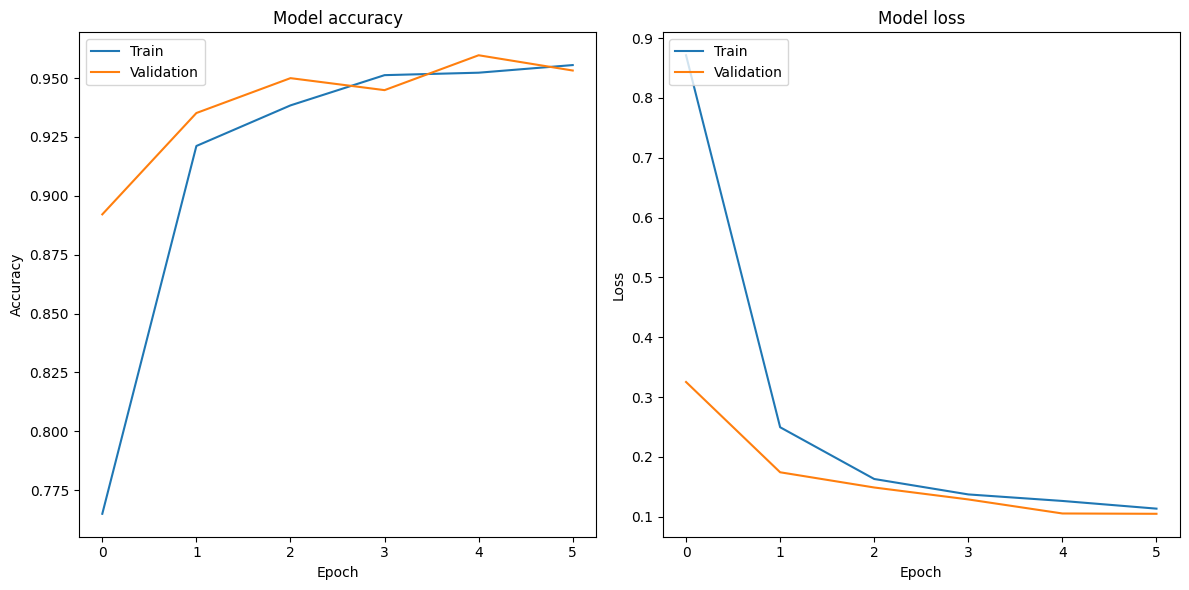

In [7]:
import matplotlib.pyplot as plt
# Plot training history: accuracy and loss over epochs
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import classification_report  # Import classification_report
import numpy as np
# Evaluate the model
predictions = model.predict(validation_generator)
print(predictions)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Print classification report
class_names = list(validation_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

68/68 [==============================] - 67s 966ms/step
[[2.8413970e-07 1.8994635e-07 8.1816543e-06 ... 8.4915975e-08
  1.0663110e-10 2.7005769e-06]
 [3.2661605e-09 8.0788705e-05 8.0042384e-10 ... 2.6382205e-09
  2.7544846e-08 4.3535021e-08]
 [2.7243502e-03 1.6609534e-04 1.6877299e-05 ... 3.0132564e-06
  3.9580113e-06 9.2039380e-05]
 ...
 [1.2440839e-06 2.3620309e-07 2.4911560e-06 ... 2.1488802e-05
  2.9915875e-05 6.6111567e-03]
 [2.8180011e-10 5.5250695e-07 4.0571809e-05 ... 3.5347190e-07
  2.5423602e-12 1.8998222e-05]
 [2.3744166e-08 2.9675014e-09 2.8562539e-08 ... 9.6354584e-11
  1.1669667e-11 4.5428841e-10]]
                                       precision    recall  f1-score   support

          botol_elektrolit_ori_pocari       0.03      0.03      0.03        40
               botol_kopi_aren_kopken       0.00      0.00      0.00        40
          botol_kopi_cappuccino_golda       0.00      0.00      0.00        40
                  botol_kopi_susu_abc       0.03      0.03     

In [11]:
model.save('mobilenetv2_1.h5')

In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model_path = '/kaggle/working/mobilenetv2.h5'  # Replace with the path to your .h5 model file

try:
    # Load the model
    model = load_model(model_path)
    print("Model loaded successfully.")
    
    # Optionally, you can compile the model if you want to train or evaluate it
    # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
except Exception as e:
    print(f"Error loading model: {e}")
    # Handle the error as needed


Model loaded successfully.
